# Introduction

- Projet final présenté par: **François Pelletier**
- Matricule: **908144032**
- Dans le cadre du cours: **IFT-7025**

# Librairies utilisées

In [4]:
import numpy as np
import load_datasets as ld
import matplotlib.pyplot as plt
import DecisionTree
import NeuralNet
import time

## Iris Dataset

La présentation des résultats liés à ce jeu de données servira aussi à expliquer les concepts et répondre aux questions. Pour les autres jeux de données, seuls les résultats et la discussion seront détaillés.

- Chargement du jeu de données

In [5]:
train1, train_labels1, test1, test_labels1 = (
    ld.load_iris_dataset(train_ratio = 0.7))

### Entrainement de l'arbre de décision

Dans cette section, on entraine un arbre de décision basé sur la mesure d'entropie.

In [6]:
dt1 = DecisionTree.DecisionTree(attribute_type="continuous")
start_time = time.time()
_ = dt1.train(train1, train_labels1,verbose=False)
dt1_compute_time = time.time() - start_time

### Courbe d'apprentissage

Je trace une courbe d'apprentissage qui effectue une validation croisée sur 10 sous-ensembles de l'ensemble d'entrainement. Je fais la moyenne de l'accuracy pour chaque sous-ensemble de test, puis j'itère en ajoutant un exemple à la fois à l'ensemble d'entrainement.

- Bogue connu: J'ai débuté la courbe d'apprentissage avec 30 données, car j'ai de la difficulté à exécuter la validation croisée avec moins sans que ça plante vu que je crée les sous-groupes à l'avance.

In [7]:
def courbe_apprentissage_dt(dt,train,train_labels,nb_cv_split=10):
    accuracy_cum = []
    range_lc = range(30,len(train_labels))
    for i in range_lc:
        range_lc_split_test = np.array_split(range(i),nb_cv_split)
        range_lc_split_train = (
            [np.setdiff1d(range(i),t) for t in range_lc_split_test])
        accuracy_cv = []
        for r_i in range(nb_cv_split):
            try:
                training = dt.train(train[range_lc_split_train[r_i]], 
                                     train_labels[range_lc_split_train[r_i]],
                                     verbose=False)
                testres = dt.test(train[range_lc_split_test[r_i]], 
                                train_labels[range_lc_split_test[r_i]],
                                verbose=False)
                accuracy_cv.append(testres[1])
            except:
                pass
        accuracy_cum.append(np.mean(accuracy_cv))
    return range_lc,accuracy_cum

In [8]:
dt_range_lc1,dt_accuracy_cum1 = courbe_apprentissage_dt(dt1,train1,train_labels1)

/home/francois/ift7025-projet/Code/metrics.py:40: RuntimeWarning: invalid value encountered in double_scalars
  myPrecision = cm[label_num,label_num] / sum(cm[:,label_num])


Voici le graphique de la courbe d'apprentissage

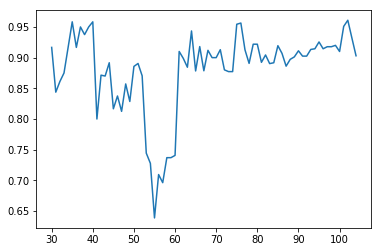

In [9]:
plt.plot(dt_range_lc1,dt_accuracy_cum1)

### Test et évaluation de la performance de l'arbre de décision

In [10]:
dt1_testres = dt1.test(test1, test_labels1)

Matrice de confusion:
[[15.  0.  0.]
 [ 0. 16.  1.]
 [ 0.  0. 13.]]

Exactitude:
0.9777777777777777

Précision:
[1.0, 1.0, 0.9285714285714286]

Rappel:
[1.0, 0.9411764705882353, 1.0]

Calculé en:
0.00035953521728515625s


### Réseaux de neurones: Choix du nombre de neurones dans la couche cachée

On doit identifier le nombre optimal de neurones dans la couche cachée dans l'intervalle $[4,50]$ pour chacun des 5 jeux de données. On itère sur chacun des jeux de validation croisée, pour chaque dimension, puis on calcule l'*accuracy* moyenne. La dimension qui a la meilleure *accuracy* moyenne est choisie pour construire le réseau de neurones.

In [11]:
choix_n_neurones = range(4,51)

- Pour faire la séparation du jeu de données en $k_{cv}=5$ jeux de validation croisée, on génère une permutation sur les indices du jeu d'entrainement, puis, on sépare cet ensemble en 5 groupes.

In [12]:
k_cv = 5
all_indices = range(len(train_labels1))
np.random.seed(12345)
indices_cv_test = (
    np.sort(np.array_split(np.random.permutation(all_indices),
                           k_cv)))

In [13]:
indices_cv_train = (
    [np.setdiff1d(all_indices,indices_cv_test[i]) for i in range(k_cv)])

Ce jeu de données a trois classes possibles comme variable de sortie. On utilisera donc un réseau de neurones avec 3 neurones dans la couche de sortie, une pour chacune des valeurs possibles. Les valeurs de sortie du jeu de données sont transformées à l'aide d'un encodage binaire où la valeur de sortie est convertie en rang dans un vecteur (on commence à 0), prenant la valeur 1. Par exemple, la valeur 2 devient $[0,0,1]$.

In [14]:
accuracy_cum = []
for n_neurones in choix_n_neurones:
    accuracy_cv=[]
    for cv_set in range(k_cv):
        nn1 = NeuralNet.NeuralNet(np.array([4,n_neurones,3]),range(3))
        nn1.train(train1[indices_cv_train[cv_set]], 
                  train_labels1[indices_cv_train[cv_set]], 0.1, 1, 
                  verbose=False)
        _,accuracy,_,_,_ = nn1.test(train1[indices_cv_test[cv_set]], 
                                    train_labels1[indices_cv_test[cv_set]], 
                                    verbose=False)
        accuracy_cv.append(accuracy)
    accuracy_cum.append(np.mean(np.array(accuracy_cv)))

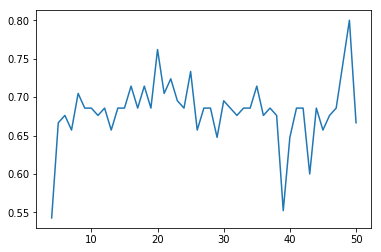

In [15]:
plt.plot(choix_n_neurones,accuracy_cum)

Le nombre de neurones qui maximise l'*accuracy* est de:

In [16]:
n_neurones_optimal1 = (
    choix_n_neurones[np.where(accuracy_cum==max(accuracy_cum))[0][0]])
n_neurones_optimal1

49

### Choix du nombre de couches cachées

On choisit un nombre de 1 à 5 couches cachées. Le nombre de couches ayant l'*accuracy* maximale sera sélectionné pour la construction du réseau. On effectue 10 époques étant donné la taille des réseaux à entrainer.

In [17]:
choix_n_couches = range(1,6)

In [18]:
accuracy_cum = []
lc_cum = []
for n_couches in choix_n_couches:
    accuracy_cv=[]
    nn1 = NeuralNet.NeuralNet(
        np.hstack((4,
                   np.repeat(n_neurones_optimal1,n_couches),
                   3)),
        range(3))
    lc = nn1.train(train1, train_labels1, 0.1, 10, verbose=False)
    lc_cum.append(lc)
    _,accuracy,_,_,_ = nn1.test(train1, train_labels1, verbose=False)
    accuracy_cv.append(accuracy)
    accuracy_cum.append(np.mean(np.array(accuracy_cv)))
lc_cum = np.array(lc_cum)

L'*accuracy* pour les différentes profondeur est de :

In [19]:
np.vstack((choix_n_couches,accuracy_cum))

array([[1.        , 2.        , 3.        , 4.        , 5.        ],
       [0.6952381 , 0.97142857, 0.88571429, 0.93333333, 0.79047619]])

Le nombre de couches cachées qui maximise l'*accuracy* est de:

In [20]:
n_couches_optimal1 = choix_n_couches[np.where(accuracy_cum==max(accuracy_cum))[0][0]]
n_couches_optimal1

2

Un problème rencontré avec un nombre de couches élevées est appelé le *Vanishing gradient problem*. Dans ces situations, le nombre de multiplications nécessaires ainsi que le fait que les valeurs $\Delta$ sont suffisamment petites pour que le gradient tende vers 0 et ainsi ne permette pas de mettre les poids à jour. Dans ces situations, l'entrainement va stagner.

### Courbes d'apprentissage

Ce graphique présente les courbes d'apprentissage pour chacun des niveaux de profondeur du réseau

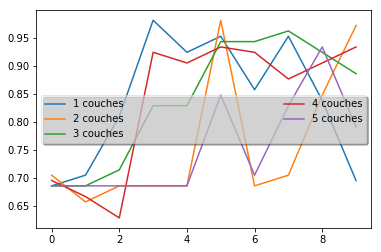

In [21]:
plt.subplot(111)
for i in choix_n_couches:
    plt.plot(range(10),lc_cum[i-1], label="%d couches"%(i,))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

### Choix des poids initiaux
Les poids initiaux ont été choisis à partir d'une distribution uniforme sur $[-1,1]$. On compare ici les courbes d'apprentissage en initialisant les poids à 0 et en initialisant les poids aléatoirement, pour le réseau de dimension et de profondeur optimale sélectionnées précédemment.

- Réseau initialisé avec les poids à 0 $RN_{0}$

In [22]:
nn1_poidszero = NeuralNet.NeuralNet(
    np.hstack((4,
               np.repeat(n_neurones_optimal1,n_couches_optimal1),
               3)),
    range(3),
    input_weights=0)
lc_nn1_poidszero = (
    nn1_poidszero.train(train1, train_labels1, 0.1, 10, verbose=False))

- Réseau initialisé avec les poids uniformes $RN_{\neg{0}}$

In [23]:
nn1_poidsunif = NeuralNet.NeuralNet(
    np.hstack((4,
               np.repeat(n_neurones_optimal1,n_couches_optimal1),
               3)),
    range(3))
np.random.seed(12345)
start_time = time.time()
lc_nn1_poidsunif = (
    nn1_poidsunif.train(train1, train_labels1, 0.1, 10, verbose=False))
nn1_compute_time = time.time() - start_time

### Graphique des courbes d'apprentissage

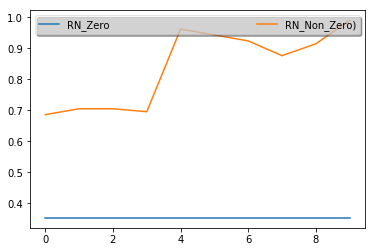

In [24]:
plt.subplot(111)
plt.plot(range(10),lc_nn1_poidszero, label="RN_Zero")
plt.plot(range(10),lc_nn1_poidsunif, label="RN_Non_Zero)")
leg = plt.legend(loc='best', 
                 ncol=2, 
                 mode="expand", 
                 shadow=True, 
                 fancybox=True)
leg.get_frame().set_alpha(0.5)

On remarque clairement que l'initialisation des poids à 0 ne permet pas de démarrer l'entrainement du réseau. Il est donc nécessaire d'initialiser les poids aléatoirement pour permettre l'apprentissage et éviter que les différentes fonctions pour calculer la rétropropagation des erreurs aient toutes des valeurs de 0.

### Entrainement et tests
On reprend les résultats du dernier entrainement, puisqu'il utilise les poids aléatoires et les hyperparamètres optimaux.

In [25]:
res_test1 = nn1_poidsunif.test(test1, test_labels1)

Matrice de confusion:
[[15.  0.  0.]
 [ 0. 16.  1.]
 [ 0.  3. 10.]]

Exactitude:
0.9111111111111111

Précision:
[1.0, 0.8421052631578947, 0.9090909090909091]

Rappel:
[1.0, 0.9411764705882353, 0.7692307692307693]

Calculé en:
0.0332188606262207s


## MONKS Dataset

- Chargement des jeux de données

In [26]:
train2, train_labels2, test2, test_labels2 = (
    ld.load_monks_dataset(1))
train3, train_labels3, test3, test_labels3 = (
    ld.load_monks_dataset(2))
train4, train_labels4, test4, test_labels4 = (
    ld.load_monks_dataset(3))

### Entrainement de l'arbre de décision

Dans cette section, on entraine un arbre de décision basé sur la mesure d'entropie.

In [27]:
dt2 = DecisionTree.DecisionTree(attribute_type="discrete")
dt3 = DecisionTree.DecisionTree(attribute_type="discrete")
dt4 = DecisionTree.DecisionTree(attribute_type="discrete")

start_time = time.time()
_ = dt2.train(train2, train_labels2,verbose=False)
dt2_compute_time = time.time() - start_time
start_time = time.time()
_ = dt3.train(train3, train_labels3,verbose=False)
dt3_compute_time = time.time() - start_time
start_time = time.time()
_ = dt4.train(train4, train_labels4,verbose=False)
dt4_compute_time = time.time() - start_time

### Courbe d'apprentissage


In [28]:
dt_range_lc2,dt_accuracy_cum2 = courbe_apprentissage_dt(dt2,train2,train_labels2)
dt_range_lc3,dt_accuracy_cum3 = courbe_apprentissage_dt(dt3,train3,train_labels3)
dt_range_lc4,dt_accuracy_cum4 = courbe_apprentissage_dt(dt4,train4,train_labels4)

Voici les graphiques de la courbe d'apprentissage pour les 3 jeux de données
- 1er jeu de données

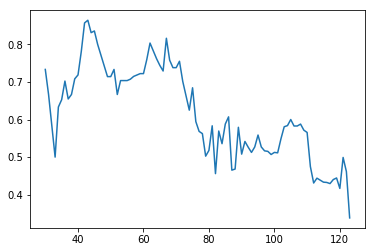

In [29]:
plt.plot(dt_range_lc2,dt_accuracy_cum2)

- 2e jeu de données

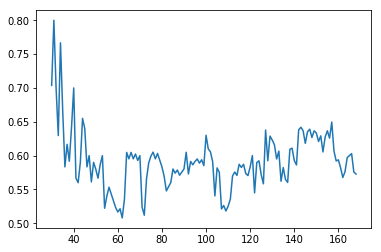

In [30]:
plt.plot(dt_range_lc3,dt_accuracy_cum3)

- 3e jeu de données

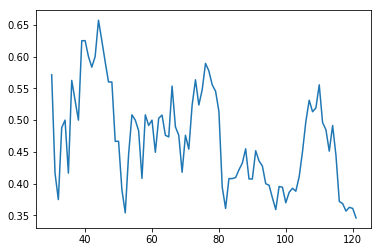

In [31]:
plt.plot(dt_range_lc4,dt_accuracy_cum4)

On peut facilement observer que dans les trois cas, il y a très peu d'apprentissage de réalisé par l'algorithme avec les exemples fournis.

### Test et évaluation de la performance de l'arbre de décision

In [32]:
dt2_testres = dt2.test(test2, test_labels2)

Matrice de confusion:
[[144.  74.]
 [131.  85.]]

Exactitude:
0.5254629629629629

Précision:
[0.5236363636363637, 0.5345911949685535]

Rappel:
[0.6605504587155964, 0.39351851851851855]

Calculé en:
0.0012059211730957031s


In [33]:
dt3_testres = dt3.test(test3, test_labels3)

Matrice de confusion:
[[219.  72.]
 [ 88.  56.]]

Exactitude:
0.6296296296296297

Précision:
[0.7133550488599348, 0.4375]

Rappel:
[0.7525773195876289, 0.3888888888888889]

Calculé en:
0.001070261001586914s


In [34]:
dt4_testres = dt4.test(test4, test_labels4)

Matrice de confusion:
[[ 30. 175.]
 [ 25. 207.]]

Exactitude:
0.5370370370370371

Précision:
[0.5454545454545454, 0.5418848167539267]

Rappel:
[0.14634146341463414, 0.8922413793103449]

Calculé en:
0.001104116439819336s


### Réseaux de neurones: choix du nombre de neurones dans la couche cachée

- Pour faire la séparation du jeu de données en $k_{cv}=5$ jeux de validation croisée, on génère une permutation sur les indices du jeu d'entrainement, puis, on sépare cet ensemble en 5 groupes.

In [35]:
all_indices2 = range(len(train_labels2))
all_indices3 = range(len(train_labels3))
all_indices4 = range(len(train_labels4))
np.random.seed(12345)
indices_cv_test2 = (
    [np.sort(x) for x in np.array_split(np.random.permutation(all_indices2),k_cv)])
np.random.seed(12345)
indices_cv_test3 = (
    [np.sort(x) for x in np.array_split(np.random.permutation(all_indices3),k_cv)])
np.random.seed(12345)
indices_cv_test4 = (
    [np.sort(x) for x in np.array_split(np.random.permutation(all_indices4),k_cv)])

In [36]:
indices_cv_train2 = (
    [np.setdiff1d(all_indices,indices_cv_test2[i]) for i in range(k_cv)])
indices_cv_train3 = (
    [np.setdiff1d(all_indices,indices_cv_test3[i]) for i in range(k_cv)])
indices_cv_train4 = (
    [np.setdiff1d(all_indices,indices_cv_test4[i]) for i in range(k_cv)])

Ces jeux de données ont deux classes possibles comme variable de sortie. On utilisera donc un réseau de neurones avec deux neurone dans la couche de sortie, une pour chacune des valeurs possibles. Les valeurs de sortie du jeu de données sont transformées à l'aide d'un encodage binaire où la valeur de sortie est convertie en rang dans un vecteur (on commence à 0), prenant la valeur 1. Par exemple, la valeur 1 devient $[0,1]$.

In [37]:
accuracy_cum2 = []
for n_neurones in choix_n_neurones:
    accuracy_cv=[]
    for cv_set in range(k_cv):
        nn2 = NeuralNet.NeuralNet(np.array([6,n_neurones,2]),range(2))
        nn2.train(train2[indices_cv_train2[cv_set]], 
                  train_labels2[indices_cv_train2[cv_set]], 0.1, 1, 
                  verbose=False)
        _,accuracy,_,_,_ = nn2.test(train2[indices_cv_test2[cv_set]], 
                                    train_labels2[indices_cv_test2[cv_set]], 
                                    verbose=False)
        accuracy_cv.append(accuracy)
    accuracy_cum2.append(np.mean(np.array(accuracy_cv)))

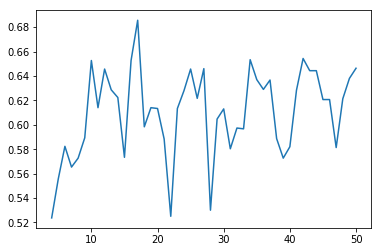

In [38]:
plt.plot(choix_n_neurones,accuracy_cum2)

Le nombre de neurones qui maximise l'accuracy est de:

In [39]:
n_neurones_optimal2 = (
    choix_n_neurones[np.where(accuracy_cum2==max(accuracy_cum2))[0][0]])
n_neurones_optimal2

17

In [40]:
accuracy_cum3 = []
for n_neurones in choix_n_neurones:
    accuracy_cv=[]
    for cv_set in range(k_cv):
        nn3 = NeuralNet.NeuralNet(np.array([6,n_neurones,2]),range(2))
        nn3.train(train3[indices_cv_train3[cv_set]], 
                  train_labels3[indices_cv_train3[cv_set]], 0.1, 1, 
                  verbose=False)
        _,accuracy,_,_,_ = nn3.test(train3[indices_cv_test3[cv_set]], 
                                    train_labels3[indices_cv_test3[cv_set]], 
                                    verbose=False)
        accuracy_cv.append(accuracy)
    accuracy_cum3.append(np.mean(np.array(accuracy_cv)))

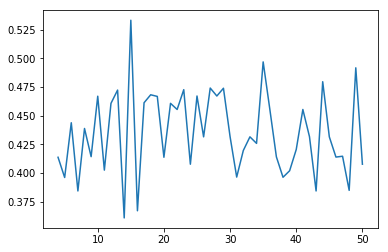

In [41]:
plt.plot(choix_n_neurones,accuracy_cum3)

Le nombre de neurones qui maximise l'accuracy est de:

In [42]:
n_neurones_optimal3 = (
    choix_n_neurones[np.where(accuracy_cum3==max(accuracy_cum3))[0][0]])
n_neurones_optimal3

15

In [43]:
accuracy_cum4 = []
for n_neurones in choix_n_neurones:
    accuracy_cv=[]
    for cv_set in range(k_cv):
        nn4 = NeuralNet.NeuralNet(np.array([6,n_neurones,2]),range(2))
        nn4.train(train4[indices_cv_train4[cv_set]], 
                  train_labels4[indices_cv_train4[cv_set]], 0.1, 1, 
                  verbose=False)
        _,accuracy,_,_,_ = nn4.test(train4[indices_cv_test4[cv_set]], 
                                    train_labels4[indices_cv_test4[cv_set]], 
                                    verbose=False)
        accuracy_cv.append(accuracy)
    accuracy_cum4.append(np.mean(np.array(accuracy_cv)))

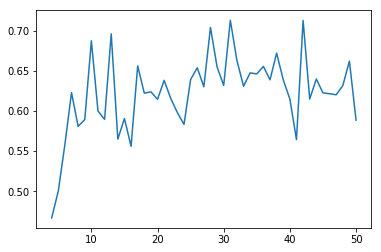

In [44]:
plt.plot(choix_n_neurones,accuracy_cum4)

Le nombre de neurones qui maximise l'*accuracy* est de:

In [45]:
n_neurones_optimal4 = (
    choix_n_neurones[np.where(accuracy_cum4==max(accuracy_cum4))[0][0]])
n_neurones_optimal4

31

### Choix du nombre de couches cachées

In [46]:
def accuracy_couches(train,train_labels,n_neurones_optimal):
    accuracy_cum = []
    lc_cum = []
    for n_couches in choix_n_couches:
        accuracy_cv=[]
        nn = NeuralNet.NeuralNet(
            np.hstack((6,
                       np.repeat(n_neurones_optimal,n_couches),
                       2)),
            range(2))
        lc = nn.train(train, train_labels, 0.1, 10, verbose=False)
        lc_cum.append(lc)
        _,accuracy,_,_,_ = nn.test(train, train_labels, verbose=False)
        accuracy_cv.append(accuracy)
        accuracy_cum.append(np.mean(np.array(accuracy_cv)))
    lc_cum = np.array(lc_cum)
    return accuracy_cum, lc_cum

In [47]:
accuracy_cum2, lc_cum2 = accuracy_couches(train2,train_labels2,n_neurones_optimal2)
accuracy_cum3, lc_cum3 = accuracy_couches(train3,train_labels3,n_neurones_optimal3)
accuracy_cum4, lc_cum4 = accuracy_couches(train4,train_labels4,n_neurones_optimal4)

L'*accuracy* pour les différentes profondeur est respectivement (un jeu de données par ligne) de :

In [48]:
np.vstack((choix_n_couches,accuracy_cum2,accuracy_cum3,accuracy_cum4))

array([[1.        , 2.        , 3.        , 4.        , 5.        ],
       [0.54032258, 0.5       , 0.48387097, 0.58064516, 0.5       ],
       [0.62130178, 0.62130178, 0.62130178, 0.62130178, 0.62130178],
       [0.62295082, 0.69672131, 0.87704918, 0.51639344, 0.50819672]])

Le nombre de couches cachées qui maximise l'*accuracy* est, pour chacun des 3 jeux de données, respectivement de:

In [49]:
n_couches_optimal2 = choix_n_couches[np.where(accuracy_cum2==max(accuracy_cum2))[0][0]]
n_couches_optimal3 = choix_n_couches[np.where(accuracy_cum3==max(accuracy_cum3))[0][0]]
n_couches_optimal4 = choix_n_couches[np.where(accuracy_cum4==max(accuracy_cum4))[0][0]]
(n_couches_optimal2,n_couches_optimal3,n_couches_optimal4)

(4, 1, 3)

### Courbes d'apprentissage

Ce graphique présente les courbes d'apprentissage pour chacun des niveaux de profondeur du réseau

- MONKS1

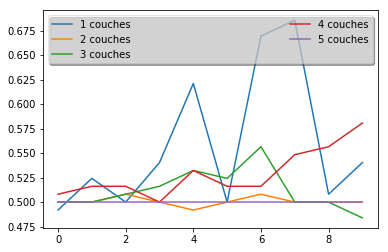

In [50]:
plt.subplot(111)
for i in choix_n_couches:
    plt.plot(range(10),lc_cum2[i-1], label="%d couches"%(i,))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

- MONKS2

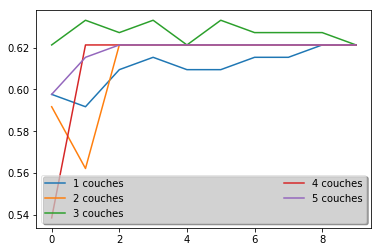

In [51]:
plt.subplot(111)
for i in choix_n_couches:
    plt.plot(range(10),lc_cum3[i-1], label="%d couches"%(i,))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

- MONKS3

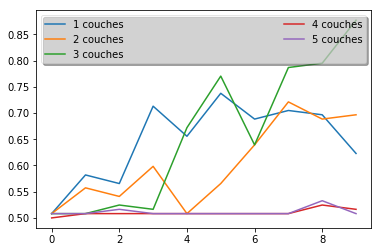

In [52]:
plt.subplot(111)
for i in choix_n_couches:
    plt.plot(range(10),lc_cum4[i-1], label="%d couches"%(i,))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

### Choix des poids initiaux
Les poids initiaux ont été choisis à partir d'une distribution uniforme sur $[-1,1]$. On compare ici les courbes d'apprentissage en initialisant les poids à 0 et en initialisant les poids aléatoirement, pour le réseau de dimension et de profondeur optimale sélectionnées précédemment.

- Réseau initialisé avec les poids à 0 $RN_{0}$

In [53]:
nn2_poidszero = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal2,n_couches_optimal2),
               2)),
    range(2),
    input_weights=0)
lc_nn2_poidszero = (
    nn2_poidszero.train(train2, train_labels2, 0.1, 10, verbose=False))

In [54]:
nn3_poidszero = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal3,n_couches_optimal3),
               2)),
    range(2),
    input_weights=0)
lc_nn3_poidszero = (
    nn3_poidszero.train(train3, train_labels3, 0.1, 10, verbose=False))

In [55]:
nn4_poidszero = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal4,n_couches_optimal4),
               2)),
    range(2),
    input_weights=0)
lc_nn4_poidszero = (
    nn4_poidszero.train(train4, train_labels4, 0.1, 10, verbose=False))

- Réseau initialisé avec les poids uniformes $RN_{\neg{0}}$

In [56]:
nn2_poidsunif = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal2,n_couches_optimal2),
               2)),
    range(2))
np.random.seed(12345)
start_time = time.time()
lc_nn2_poidsunif = (
    nn2_poidsunif.train(train2, train_labels2, 0.1, 10, verbose=False))
nn2_compute_time = time.time() - start_time

In [57]:
nn3_poidsunif = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal3,n_couches_optimal3),
               2)),
    range(2))
np.random.seed(12345)
start_time = time.time()
lc_nn3_poidsunif = (
    nn3_poidsunif.train(train3, train_labels3, 0.1, 10, verbose=False))
nn3_compute_time = time.time() - start_time

In [58]:
nn4_poidsunif = NeuralNet.NeuralNet(
    np.hstack((6,
               np.repeat(n_neurones_optimal4,n_couches_optimal4),
               2)),
    range(2))
np.random.seed(12345)
start_time = time.time()
lc_nn4_poidsunif = (
    nn4_poidsunif.train(train4, train_labels4, 0.1, 10, verbose=False))
nn4_compute_time = time.time() - start_time

### Graphique des courbes d'apprentissage

- MONKS1

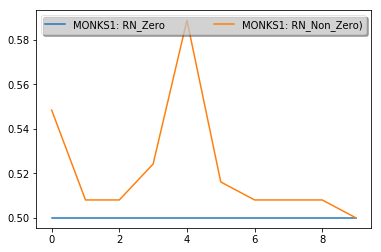

In [59]:
plt.subplot(111)
plt.plot(range(10),lc_nn2_poidszero, label="MONKS1: RN_Zero")
plt.plot(range(10),lc_nn2_poidsunif, label="MONKS1: RN_Non_Zero)")
leg = plt.legend(loc='best', 
                 ncol=2, 
                 mode="expand", 
                 shadow=True, 
                 fancybox=True)
leg.get_frame().set_alpha(0.5)

- MONKS2

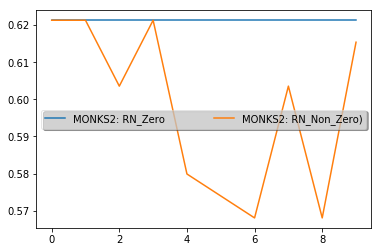

In [60]:
plt.subplot(111)
plt.plot(range(10),lc_nn3_poidszero, label="MONKS2: RN_Zero")
plt.plot(range(10),lc_nn3_poidsunif, label="MONKS2: RN_Non_Zero)")
leg = plt.legend(loc='best', 
                 ncol=2, 
                 mode="expand", 
                 shadow=True, 
                 fancybox=True)
leg.get_frame().set_alpha(0.5)

- MONKS3

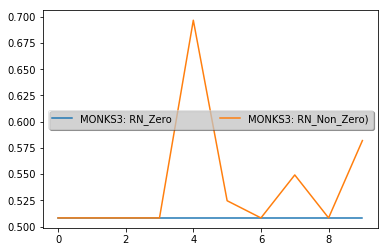

In [61]:
plt.subplot(111)
plt.plot(range(10),lc_nn4_poidszero, label="MONKS3: RN_Zero")
plt.plot(range(10),lc_nn4_poidsunif, label="MONKS3: RN_Non_Zero)")
leg = plt.legend(loc='best', 
                 ncol=2, 
                 mode="expand", 
                 shadow=True, 
                 fancybox=True)
leg.get_frame().set_alpha(0.5)

On remarque ici aussi que l'initialisation des poids à 0 ne permet pas de démarrer l'entrainement du réseau. Dans le second jeu de données, cependant, l'initialisation aléatoire ne permet pas non plus de démarrer l'apprentissage.

### Entrainement et tests
On reprend les résultats du dernier entrainement, puisqu'il utilise les poids aléatoires et les hyperparamètres optimaux.

In [62]:
res_test2 = nn2_poidsunif.test(test2, test_labels2)

Matrice de confusion:
[[  0. 216.]
 [  1. 215.]]

Exactitude:
0.4976851851851852

Précision:
[0.0, 0.4988399071925754]

Rappel:
[0.0, 0.9953703703703703]

Calculé en:
0.20783138275146484s


In [63]:
res_test3 = nn3_poidsunif.test(test3, test_labels3)

Matrice de confusion:
[[255.  35.]
 [126.  16.]]

Exactitude:
0.6273148148148148

Précision:
[0.6692913385826772, 0.3137254901960784]

Rappel:
[0.8793103448275862, 0.11267605633802817]

Calculé en:
0.04411029815673828s


In [64]:
res_test4 = nn4_poidsunif.test(test4, test_labels4)

Matrice de confusion:
[[203.   1.]
 [199.  29.]]

Exactitude:
0.5370370370370371

Précision:
[0.5049751243781094, 0.9666666666666667]

Rappel:
[0.9950980392156863, 0.12719298245614036]

Calculé en:
0.2925841808319092s


## Congressionnal Dataset

- Chargement du jeu de données

In [65]:
train5, train_labels5, test5, test_labels5 = (
    ld.load_congressional_dataset(train_ratio = 0.7))

### Entrainement de l'arbre de décision

Dans cette section, on entraine un arbre de décision basé sur la mesure d'entropie.

In [66]:
dt5 = DecisionTree.DecisionTree(attribute_type="discrete")
start_time = time.time()
_ = dt5.train(train5, train_labels5, verbose=False)
dt5_compute_time = time.time() - start_time

### Courbe d'apprentissage

In [67]:
dt_range_lc5,dt_accuracy_cum5 = courbe_apprentissage_dt(dt5,train5,train_labels5)

Voici le graphique de la courbe d'apprentissage

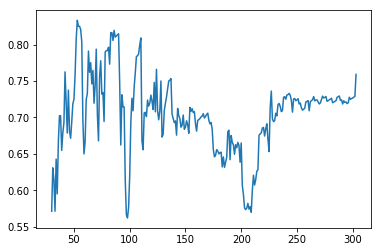

In [68]:
plt.plot(dt_range_lc5,dt_accuracy_cum5)

### Test et évaluation de la performance de l'arbre de décision

In [69]:
dt5_testres = dt5.test(test5, test_labels5)

Matrice de confusion:
[[26. 36.]
 [ 8. 67.]]

Exactitude:
0.6641221374045801

Précision:
[0.7647058823529411, 0.6504854368932039]

Rappel:
[0.41935483870967744, 0.8933333333333333]

Calculé en:
0.0005872249603271484s


### Réseaux de neurones: Choix du nombre de neurones dans la couche cachée

- Pour faire la séparation du jeu de données en $k_{cv}=5$ jeux de validation croisée, on génère une permutation sur les indices du jeu d'entrainement, puis, on sépare cet ensemble en 5 groupes.

In [70]:
all_indices5 = range(len(train_labels5))
np.random.seed(12345)
indices_cv_test5 = (
    [np.sort(x) for x in (np.array_split(np.random.permutation(all_indices5),
                           k_cv))])

In [71]:
indices_cv_train5 = (
    [np.setdiff1d(all_indices5,indices_cv_test5[i]) for i in range(k_cv)])

Ce jeux de données a trois classes possibles comme variable de sortie. On utilisera donc un réseau de neurones avec 3 neurones dans la couche de sortie, une pour chacune des valeurs possibles. Les valeurs de sortie du jeu de données sont transformées à l'aide d'un encodage binaire où la valeur de sortie est convertie en rang dans un vecteur (on commence à 0), prenant la valeur 1. Par exemple, la valeur 2 devient $[0,0,1]$.

In [72]:
accuracy_cum5 = []
for n_neurones in choix_n_neurones:
    accuracy_cv=[]
    for cv_set in range(k_cv):
        accuracy=0
        try:
            nn5 = NeuralNet.NeuralNet(np.array([16,n_neurones,3]),range(3))
            nn5.train(train5[indices_cv_train5[cv_set]], 
                      train_labels5[indices_cv_train5[cv_set]], 0.1, 1, 
                      verbose=False)
            _,accuracy,_,_,_ = nn5.test(train5[indices_cv_test5[cv_set]], 
                                        train_labels5[indices_cv_test5[cv_set]], 
                                        verbose=False)
        except:
            pass
        accuracy_cv.append(accuracy)
    accuracy_cum5.append(np.mean(np.array(accuracy_cv)))

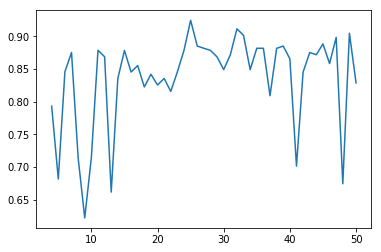

In [73]:
plt.plot(choix_n_neurones,accuracy_cum5)

Le nombre de neurones qui maximise l'*accuracy* est de:

In [74]:
n_neurones_optimal5 = (
    choix_n_neurones[np.where(accuracy_cum5==max(accuracy_cum5))[0][0]])
n_neurones_optimal5

25

### Choix du nombre de couches cachées

In [75]:
accuracy_cum5 = []
lc_cum5 = []
for n_couches in choix_n_couches:
    accuracy_cv=[]
    nn5 = NeuralNet.NeuralNet(
        np.hstack((16,
                   np.repeat(n_neurones_optimal5,n_couches),
                   3)),
        range(3))
    lc = nn5.train(train5, train_labels5, 0.1, 10, verbose=False)
    lc_cum5.append(lc)
    _,accuracy,_,_,_ = nn5.test(train5, train_labels5, verbose=False)
    accuracy_cv.append(accuracy)
    accuracy_cum5.append(np.mean(np.array(accuracy_cv)))
lc_cum5 = np.array(lc_cum5)

L'*accuracy* pour les différentes profondeur est de :

In [76]:
np.vstack((choix_n_couches,accuracy_cum5))

array([[1.        , 2.        , 3.        , 4.        , 5.        ],
       [0.94736842, 0.92105263, 0.92763158, 0.90460526, 0.8125    ]])

Le nombre de couches cachées qui maximise l'*accuracy* est de:

In [77]:
n_couches_optimal5 = choix_n_couches[np.where(accuracy_cum5==max(accuracy_cum5))[0][0]]
n_couches_optimal5

1

### Courbes d'apprentissage

Ce graphique présente les courbes d'apprentissage pour chacun des niveaux de profondeur du réseau

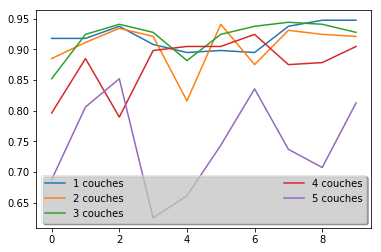

In [78]:
plt.subplot(111)
for i in choix_n_couches:
    plt.plot(range(10),lc_cum5[i-1], label="%d couches"%(i,))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

### Choix des poids initiaux
Les poids initiaux ont été choisis à partir d'une distribution uniforme sur $[-1,1]$. On compare ici les courbes d'apprentissage en initialisant les poids à 0 et en initialisant les poids aléatoirement, pour le réseau de dimension et de profondeur optimale sélectionnées précédemment.

- Réseau initialisé avec les poids à 0 $RN_{0}$

In [79]:
nn5_poidszero = NeuralNet.NeuralNet(
    np.hstack((16,
               np.repeat(n_neurones_optimal5,n_couches_optimal5),
               3)),
    range(3),
    input_weights=0)
lc_nn5_poidszero = (
    nn5_poidszero.train(train5, train_labels5, 0.1, 10, verbose=False))

- Réseau initialisé avec les poids uniformes $RN_{\neg{0}}$

In [80]:
nn5_poidsunif = NeuralNet.NeuralNet(
    np.hstack((16,
               np.repeat(n_neurones_optimal5,n_couches_optimal5),
               3)),
    range(3))
np.random.seed(12345)
start_time = time.time()
lc_nn5_poidsunif = (
    nn5_poidsunif.train(train5, train_labels5, 0.1, 10, verbose=False))
nn5_compute_time = time.time() - start_time

### Graphique des courbes d'apprentissage

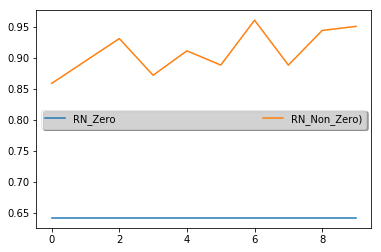

In [81]:
plt.subplot(111)
plt.plot(range(10),lc_nn5_poidszero, label="RN_Zero")
plt.plot(range(10),lc_nn5_poidsunif, label="RN_Non_Zero)")
leg = plt.legend(loc='best', 
                 ncol=2, 
                 mode="expand", 
                 shadow=True, 
                 fancybox=True)
leg.get_frame().set_alpha(0.5)

On remarque ici aussi que l'initialisation des poids à 0 ne permet pas de démarrer l'entrainement du réseau.

### Entrainement et tests
On reprend les résultats du dernier entrainement, puisqu'il utilise les poids aléatoires et les hyperparamètres optimaux.

In [82]:
res_test5 = nn5_poidsunif.test(test5, test_labels5)

Matrice de confusion:
[[57.  2.]
 [ 7. 65.]]

Exactitude:
0.9312977099236641

Précision:
[0.890625, 0.9701492537313433]

Rappel:
[0.9661016949152542, 0.9027777777777778]

Calculé en:
0.02217245101928711s


## Comparaison entre arbre de décision et réseau de neurones

- Taux d'erreur sur l'ensemble de test. Sur la première ligne, les erreurs pour les arbres de décision, sur la seconde, pour les réseaux de neurones

In [86]:
np.array([[dt1_testres[1],
           dt2_testres[1],
           dt3_testres[1],
           dt4_testres[1],
           dt5_testres[1]],
          [res_test1[1],
           res_test2[1],
           res_test3[1],
           res_test4[1],
           res_test5[1]]])

array([[0.97777778, 0.52546296, 0.62962963, 0.53703704, 0.66412214],
       [0.91111111, 0.49768519, 0.62731481, 0.53703704, 0.93129771]])

- Temps de prédiction d’un seul exemple. Sur la première ligne, les temps de prédiction moyens pour un exemple de l'ensemble de test pour les arbres de décision, sur la seconde, pour les réseaux de neurones

In [87]:
np.array([[dt1_testres[4]/len(test_labels1),
           dt2_testres[4]/len(test_labels2),
           dt3_testres[4]/len(test_labels3),
           dt4_testres[4]/len(test_labels4),
           dt5_testres[4]/len(test_labels5)],
          [res_test1[4]/len(test_labels1),
           res_test2[4]/len(test_labels2),
           res_test3[4]/len(test_labels3),
           res_test4[4]/len(test_labels4),
           res_test5[4]/len(test_labels5)]])

array([[7.98967150e-06, 2.79148420e-06, 2.47745602e-06, 2.55582509e-06,
        4.48263328e-06],
       [7.38196903e-04, 4.81091164e-04, 1.02107172e-04, 6.77278196e-04,
        1.69255351e-04]])

- Temps d’apprentissage du modèle. Sur la première ligne, les temps d'entrainement pour les arbres de décision, sur la seconde, pour les réseaux de neurones

In [88]:
np.array([
    [dt1_compute_time,
     dt2_compute_time,
     dt3_compute_time,
     dt4_compute_time,
     dt5_compute_time],
    [nn1_compute_time,
     nn2_compute_time,
     nn3_compute_time,
     nn4_compute_time,
     nn5_compute_time]])

array([[1.85799599e-02, 2.40612030e-03, 2.02822685e-03, 1.84917450e-03,
        9.10449028e-03],
       [4.40478587e+00, 3.11064458e+00, 8.43454361e-01, 4.58273411e+00,
        2.55364871e+00]])

## Conclusion

Les arbres de décisions sont des algorithmes simples à mettre en oeuvre et démontrent une exactitude supérieure et comparable aux arbres de décisions lorsque le nombre d'attributs est limité. Cependant, lorsque le nombre d'attributs croît, les réseaux de neurones sont beaucoup plus performants. Ceci est démontré entre autres par la performance sur le jeu de données Congressionnal où le réseau de neurones est beaucoup plus performant. Pour les jeux de données plus difficiles tels que MONKS, on ne remarque pas une grande différence entre les deux algorithmes au niveau du taux d'erreur.

Le temps de prédiction est deux ordres de magnitude plus élevé pour les réseaux de neurones que pour les arbres de décisions, car il faut effectuer toutes les multiplications des valeurs par les poids pour chacune des couches, ce qui est une opération $O(d^2)$ pour une dimension $d$. Pour l'arbre de décision, la prédiction est une recherche dans un arbre binaire, de complexité $O(log_2(d))$ pour une profondeur $d$.

Les réseaux de neurones nécessitent beaucoup plus de temps d'entrainement que les arbres de décisions, et il faut aussi considérer que ce temps est multiplié lorsque l'on effectue une recherche des hyperparamètres optimaux. Ce besoin de capacités physique explique pourquoi il a fallu attendre l'apparition des processeurs graphiques très performants pour que la recherche avec les réseaux de neurones explose. La complexité est d'autant plus élevée, car le nombre de connexions croit de façon exponentielle avec l'ajout de nouvelles couches cachées.